# Модель Diebold-Li для моделирования кривой процентных ставок

Модель Diebold-Li (2006) - упрощенная параметрическая модель для аппроксимации кривой доходности с использованием 3 параметров:
- β₀: уровень долгосрочной процентной ставки (level)
- β₁: краткосрочный компонент (slope)
- β₂: среднесрочный компонент (curvature)
- τ: временной параметр (**фиксирован τ = 2 года**, как в оригинальной статье)

Формула: y(t) = β₀ + β₁ × [(1 - e^(-t/τ))/(t/τ)] + β₂ × [(1 - e^(-t/τ))/(t/τ) - e^(-t/τ)]

**Метод оценки:** Ordinary Least Squares (OLS) - при фиксированном τ модель линейна по параметрам!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

# Настройки для визуализации
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10


In [2]:
# Загрузка данных
df = pd.read_csv('data.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.set_index('date', inplace=True)

print(f"Данные загружены: {df.shape[0]} наблюдений")
print(f"Сроки погашения (лет): {df.columns.tolist()}")
print(f"\nПериод данных: с {df.index[0].date()} по {df.index[-1].date()}")
df.head()


Данные загружены: 1256 наблюдений
Сроки погашения (лет): ['0.25', '0.5', '0.75', '1', '2', '3', '5', '7', '10', '15', '20', '30']

Период данных: с 2020-11-02 по 2025-10-31


,0.25,0.5,0.75,1,2,3,5,7,10,15,20,30
date,,,,,,,,,,,,
2020-11-02,4.35,4.36,4.38,4.42,4.69,5.02,5.64,6.10,6.52,6.85,7.01,7.18
2020-11-03,4.38,4.38,4.40,4.43,4.69,5.01,5.61,6.06,6.50,6.86,7.03,7.20
2020-11-05,4.37,4.36,4.37,4.39,4.58,4.84,5.37,5.79,6.21,6.55,6.72,6.90
2020-11-06,4.26,4.26,4.29,4.32,4.54,4.81,5.33,5.75,6.16,6.51,6.68,6.85
2020-11-09,4.30,4.29,4.30,4.33,4.53,4.78,5.28,5.68,6.10,6.44,6.61,6.79


In [3]:
class DieboldLiModel:
    """
    Модель Diebold-Li для моделирования кривой процентных ставок.
    
    Формула: y(t) = β₀ + β₁ × [(1 - e^(-t/τ))/(t/τ)] + β₂ × [(1 - e^(-t/τ))/(t/τ) - e^(-t/τ)]
    
    Параметры:
    - β₀ (beta0): уровень долгосрочной процентной ставки (level)
    - β₁ (beta1): краткосрочный компонент (slope)
    - β₂ (beta2): среднесрочный компонент (curvature)
    - τ (tau): временной параметр (фиксирован τ = 2.0, как в оригинальной статье)
    
    Метод оценки: Ordinary Least Squares (OLS)
    При фиксированном τ модель становится линейной по β → аналитическое решение!
    """
    
    def __init__(self, tau=2.0):
        """
        Инициализация модели.
        
        Parameters:
        -----------
        tau : float, default=2.0
            Фиксированный временной параметр (по умолчанию 2 года, как у Diebold-Li)
        """
        self.tau = tau
        self.params = None
        self.fitted = False
        
    def yield_curve(self, t, beta0, beta1, beta2):
        """
        Вычисляет доходность для заданных сроков погашения.
        
        Parameters:
        -----------
        t : array-like
            Сроки погашения
        beta0, beta1, beta2 : float
            Параметры модели
            
        Returns:
        --------
        array : доходности для заданных сроков
        """
        t = np.array(t, dtype=float)
        
        # Избегаем деления на ноль для t ≈ 0
        eps = 1e-10
        t = np.where(t < eps, eps, t)
        
        # Компоненты модели
        ratio = t / self.tau
        exp_term = np.exp(-ratio)
        
        # [(1 - e^(-t/τ))/(t/τ)]
        term1 = (1 - exp_term) / ratio
        
        # [(1 - e^(-t/τ))/(t/τ) - e^(-t/τ)]
        term2 = term1 - exp_term
        
        return beta0 + beta1 * term1 + beta2 * term2
    

    
    def fit(self, t, yields):
        """
        Обучает модель на данных методом OLS.
        
        Parameters:
        -----------
        t : array-like
            Сроки погашения
        yields : array-like
            Наблюденные доходности
            
        Returns:
        --------
        self
        """
        t = np.array(t, dtype=float)
        yields = np.array(yields, dtype=float)
        
        # Избегаем деления на ноль
        eps = 1e-10
        t = np.where(t < eps, eps, t)
        
        # Строим матрицу дизайна X
        ratio = t / self.tau
        exp_term = np.exp(-ratio)
        
        # f1(t) = [(1 - e^(-t/τ))/(t/τ)]
        f1 = (1 - exp_term) / ratio
        
        # f2(t) = [(1 - e^(-t/τ))/(t/τ) - e^(-t/τ)]
        f2 = f1 - exp_term
        
        # Матрица дизайна: [1, f1, f2]
        X = np.column_stack([np.ones_like(t), f1, f2])
        
        # Решаем OLS: β = (X^T X)^(-1) X^T y
        self.params, residuals, rank, s = np.linalg.lstsq(X, yields, rcond=None)
        
        self.fitted = True
        return self
    
    def predict(self, t):
        """
        Предсказывает доходности для заданных сроков погашения.
        
        Parameters:
        -----------
        t : array-like
            Сроки погашения
            
        Returns:
        --------
        array : предсказанные доходности
        """
        if not self.fitted:
            raise ValueError("Модель не обучена. Вызовите метод fit() сначала.")
        
        beta0, beta1, beta2 = self.params
        return self.yield_curve(t, beta0, beta1, beta2)
    
    def get_params_dict(self):
        """Возвращает параметры в виде словаря."""
        if not self.fitted:
            return None
        return {
            'β₀': self.params[0],
            'β₁': self.params[1],
            'β₂': self.params[2],
            'τ': self.tau
        }
    
    def score(self, t, yields):
        """
        Вычисляет R² и RMSE для оценки качества модели.
        
        Parameters:
        -----------
        t : array-like
            Сроки погашения
        yields : array-like
            Наблюденные доходности
            
        Returns:
        --------
        dict : метрики качества
        """
        if not self.fitted:
            raise ValueError("Модель не обучена.")
        
        predicted = self.predict(t)
        
        # R²
        ss_res = np.sum((yields - predicted) ** 2)
        ss_tot = np.sum((yields - np.mean(yields)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        # RMSE
        rmse = np.sqrt(np.mean((yields - predicted) ** 2))
        
        # MAE
        mae = np.mean(np.abs(yields - predicted))
        
        return {
            'R²': r2,
            'RMSE': rmse,
            'MAE': mae
        }

print("Класс DieboldLiModel создан успешно!")


Класс DieboldLiModel создан успешно!


In [4]:
# Обучение модели на одной дате для примера
# Возьмем первую дату из датасета

sample_date = df.index[0]
maturities = df.columns.astype(float).values
yields_sample = df.iloc[0].values

print(f"Обучение модели на дату: {sample_date.date()}")
print(f"Сроки погашения: {maturities}")
print(f"Процентные ставки: {yields_sample}")

# Создаем и обучаем модель (τ = 2.0, классический Diebold-Li)
print("\n" + "="*60)
print("МЕТОД: OLS с фиксированным τ = 2.0 (Diebold-Li, 2006)")
print("="*60)
model = DieboldLiModel(tau=2.0)
model.fit(maturities, yields_sample)

print(f"\nФиксированный τ: {model.tau:.4f}")

print("\nПараметры модели:")
params_dict = model.get_params_dict()
for param, value in params_dict.items():
    print(f"  {param} = {value:.6f}")

# Оценка качества
metrics = model.score(maturities, yields_sample)
print("\nМетрики качества:")
for metric, value in metrics.items():
    print(f"  {metric} = {value:.6f}")


Обучение модели на дату: 2020-11-02
Сроки погашения: [ 0.25  0.5   0.75  1.    2.    3.    5.    7.   10.   15.   20.   30.  ]
Процентные ставки: [4.35 4.36 4.38 4.42 4.69 5.02 5.64 6.1  6.52 6.85 7.01 7.18]

МЕТОД: OLS с фиксированным τ = 2.0 (Diebold-Li, 2006)

Фиксированный τ: 2.0000

Параметры модели:
  β₀ = 7.665751
  β₁ = -3.421651
  β₂ = -2.814499
  τ = 2.000000

Метрики качества:
  R² = 0.997744
  RMSE = 0.051765
  MAE = 0.046768


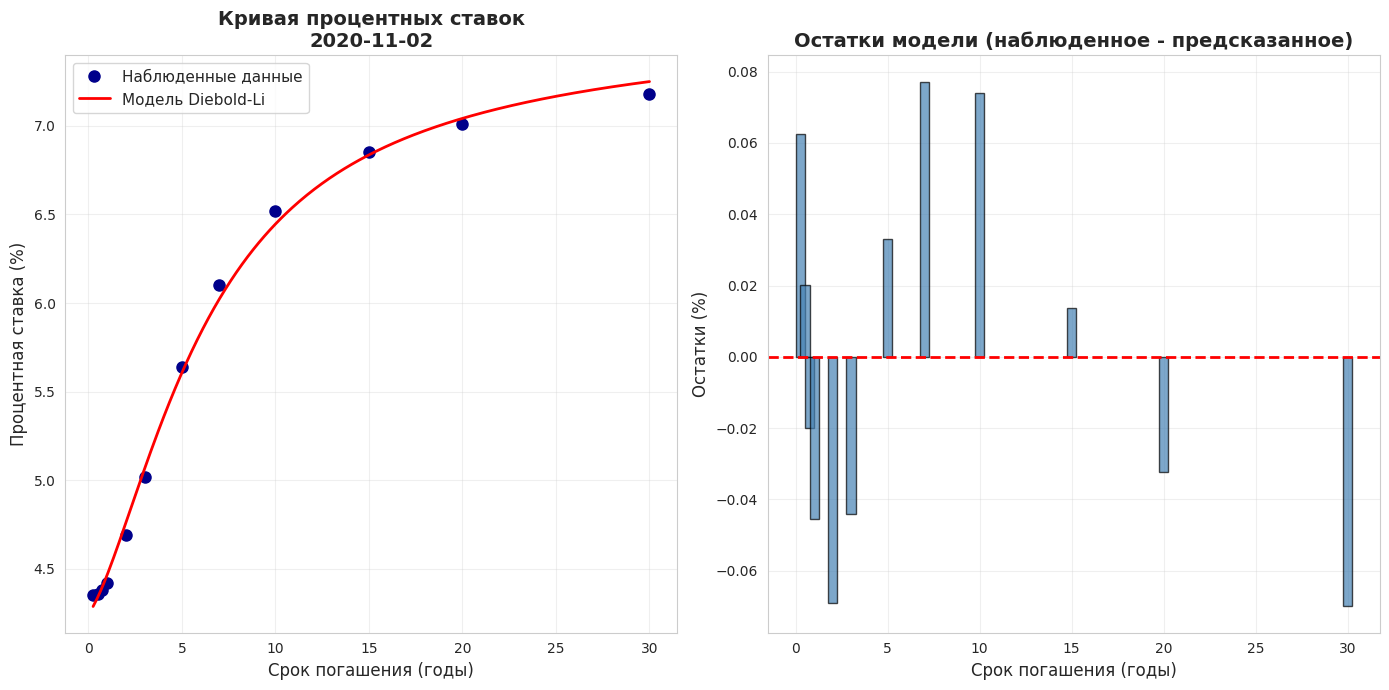

Максимальная ошибка: 0.0772%
Средняя абсолютная ошибка: 0.0468%


In [5]:
# Визуализация результатов для одной даты

# Создаем более плотную сетку для сглаженной кривой
tau_fine = np.linspace(maturities.min(), maturities.max(), 300)
predicted_fine = model.predict(tau_fine)
predicted_original = model.predict(maturities)

plt.figure(figsize=(14, 7))

# График 1: Исходные и предсказанные значения
plt.subplot(1, 2, 1)
plt.plot(maturities, yields_sample, 'o', markersize=8, label='Наблюденные данные', color='darkblue')
plt.plot(tau_fine, predicted_fine, '-', linewidth=2, label='Модель Diebold-Li', color='red')
plt.xlabel('Срок погашения (годы)', fontsize=12)
plt.ylabel('Процентная ставка (%)', fontsize=12)
plt.title(f'Кривая процентных ставок\n{sample_date.date()}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# График 2: Остатки (ошибки)
residuals = yields_sample - predicted_original
plt.subplot(1, 2, 2)
plt.bar(maturities, residuals, width=0.5, alpha=0.7, color='steelblue', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Срок погашения (годы)', fontsize=12)
plt.ylabel('Остатки (%)', fontsize=12)
plt.title('Остатки модели (наблюденное - предсказанное)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Максимальная ошибка: {np.max(np.abs(residuals)):.4f}%")
print(f"Средняя абсолютная ошибка: {np.mean(np.abs(residuals)):.4f}%")


## Обучение модели на всем датасете


In [6]:
# Обучаем модель для каждой даты в датасете
from tqdm.auto import tqdm

n_dates = len(df)
results = {
    'date': [],
    'beta0': [],
    'beta1': [],
    'beta2': [],
    'rmse': [],
    'r2': [],
    'mae': []
}

print(f"Обучение модели Diebold-Li на {n_dates} датах (τ = 2.0)...\n")

for date_idx in tqdm(range(n_dates), desc="Обучение"):
    date = df.index[date_idx]
    yields = df.iloc[date_idx].values
    
    # Создаем и обучаем модель (классический Diebold-Li)
    model_temp = DieboldLiModel(tau=2.0)
    model_temp.fit(maturities, yields)
    
    # Сохраняем результаты
    results['date'].append(date)
    results['beta0'].append(model_temp.params[0])
    results['beta1'].append(model_temp.params[1])
    results['beta2'].append(model_temp.params[2])
    
    # Метрики
    metrics = model_temp.score(maturities, yields)
    results['rmse'].append(metrics['RMSE'])
    results['r2'].append(metrics['R²'])
    results['mae'].append(metrics['MAE'])

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)
results_df.set_index('date', inplace=True)

print(f"\n✓ Модель успешно обучена на всех датах!")
print(f"\nСредние метрики качества:")
print(f"  RMSE: {results_df['rmse'].mean():.4f}")
print(f"  R²: {results_df['r2'].mean():.4f}")
print(f"  MAE: {results_df['mae'].mean():.4f}")


Обучение модели Diebold-Li на 1256 датах (τ = 2.0)...



Обучение:   0%|          | 0/1256 [00:00<?, ?it/s]


✓ Модель успешно обучена на всех датах!

Средние метрики качества:
  RMSE: 0.1203
  R²: 0.9265
  MAE: 0.0998


In [7]:
# Статистика параметров модели

print("Описательная статистика параметров модели Diebold-Li:\n")
print(results_df[['beta0', 'beta1', 'beta2']].describe())

# Выводим первые несколько строк
print("\nПервые 10 результатов:")
print(results_df.head(10))


Описательная статистика параметров модели Diebold-Li:

             beta0        beta1        beta2
count  1256.000000  1256.000000  1256.000000
mean     11.548002    -0.098698    -1.006942
std       2.696835     3.645573     3.895115
min       7.161032    -5.799821   -12.799684
25%       8.884740    -3.154655    -3.203447
50%      12.100453    -0.073437    -1.337900
75%      13.885754     1.557027     1.136637
max      16.292943    11.205763    11.022091

Первые 10 результатов:
               beta0     beta1     beta2      rmse        r2       mae
date                                                                  
2020-11-02  7.665751 -3.421651 -2.814499  0.051765  0.997744  0.046768
2020-11-03  7.694788 -3.399714 -3.028869  0.043068  0.998426  0.038936
2020-11-05  7.355787 -3.022048 -3.124984  0.031742  0.998932  0.027973
2020-11-06  7.295567 -3.080989 -2.946059  0.025869  0.999312  0.021954
2020-11-09  7.225429 -2.959070 -3.036750  0.023563  0.999386  0.020595
2020-11-10  7.31120

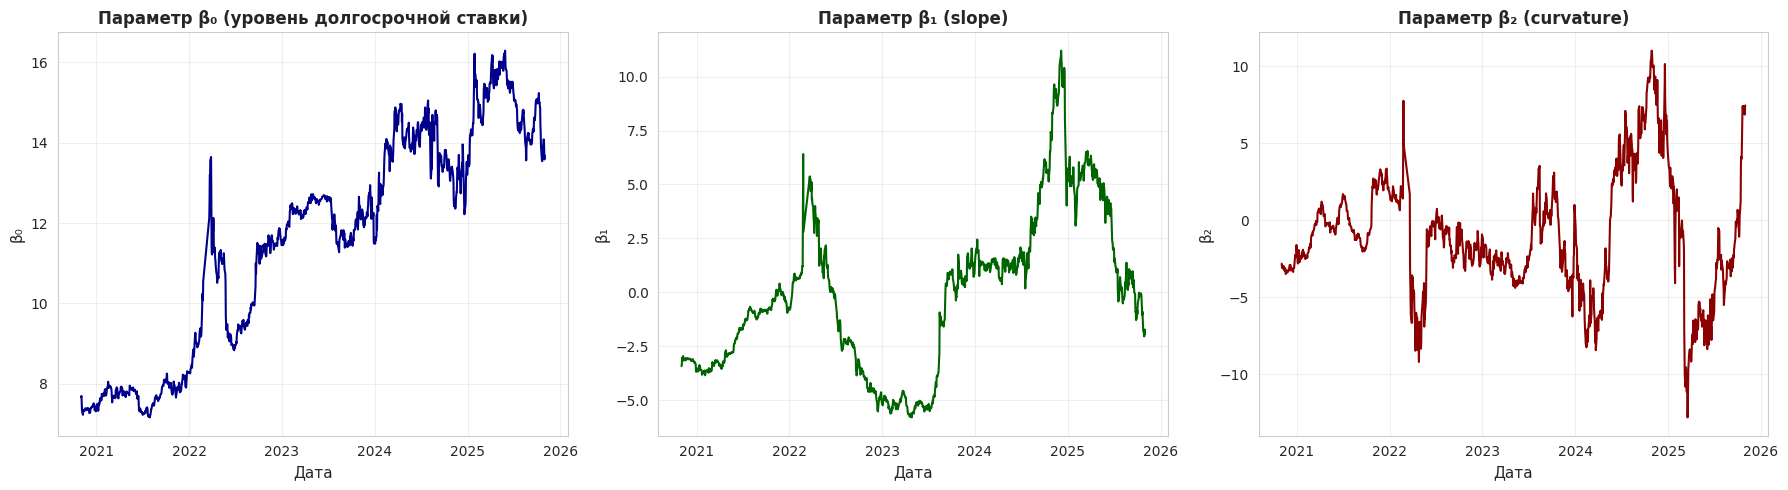

In [8]:
# Визуализация динамики параметров во времени

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# β₀ (уровень)
axes[0].plot(results_df.index, results_df['beta0'], linewidth=1.5, color='darkblue')
axes[0].set_title('Параметр β₀ (уровень долгосрочной ставки)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('β₀', fontsize=11)
axes[0].set_xlabel('Дата', fontsize=11)
axes[0].grid(True, alpha=0.3)

# β₁ (краткосрочный компонент - slope)
axes[1].plot(results_df.index, results_df['beta1'], linewidth=1.5, color='darkgreen')
axes[1].set_title('Параметр β₁ (slope)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('β₁', fontsize=11)
axes[1].set_xlabel('Дата', fontsize=11)
axes[1].grid(True, alpha=0.3)

# β₂ (среднесрочный компонент - curvature)
axes[2].plot(results_df.index, results_df['beta2'], linewidth=1.5, color='darkred')
axes[2].set_title('Параметр β₂ (curvature)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('β₂', fontsize=11)
axes[2].set_xlabel('Дата', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


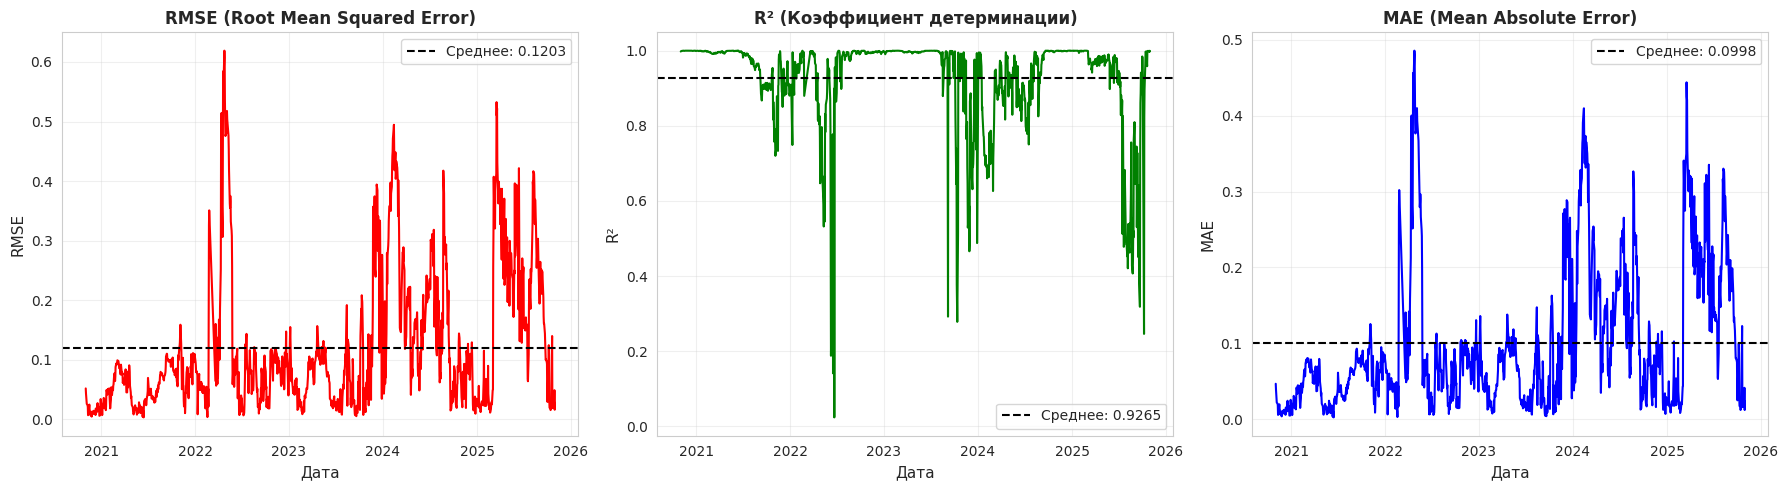

In [9]:
# Визуализация метрик качества модели

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
axes[0].plot(results_df.index, results_df['rmse'], linewidth=1.5, color='red')
axes[0].set_title('RMSE (Root Mean Squared Error)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=11)
axes[0].set_xlabel('Дата', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=results_df['rmse'].mean(), color='black', linestyle='--', 
                label=f'Среднее: {results_df["rmse"].mean():.4f}')
axes[0].legend()

# R²
axes[1].plot(results_df.index, results_df['r2'], linewidth=1.5, color='green')
axes[1].set_title('R² (Коэффициент детерминации)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R²', fontsize=11)
axes[1].set_xlabel('Дата', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=results_df['r2'].mean(), color='black', linestyle='--', 
                label=f'Среднее: {results_df["r2"].mean():.4f}')
axes[1].legend()

# MAE
axes[2].plot(results_df.index, results_df['mae'], linewidth=1.5, color='blue')
axes[2].set_title('MAE (Mean Absolute Error)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('MAE', fontsize=11)
axes[2].set_xlabel('Дата', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=results_df['mae'].mean(), color='black', linestyle='--', 
                label=f'Среднее: {results_df["mae"].mean():.4f}')
axes[2].legend()

plt.tight_layout()
plt.show()


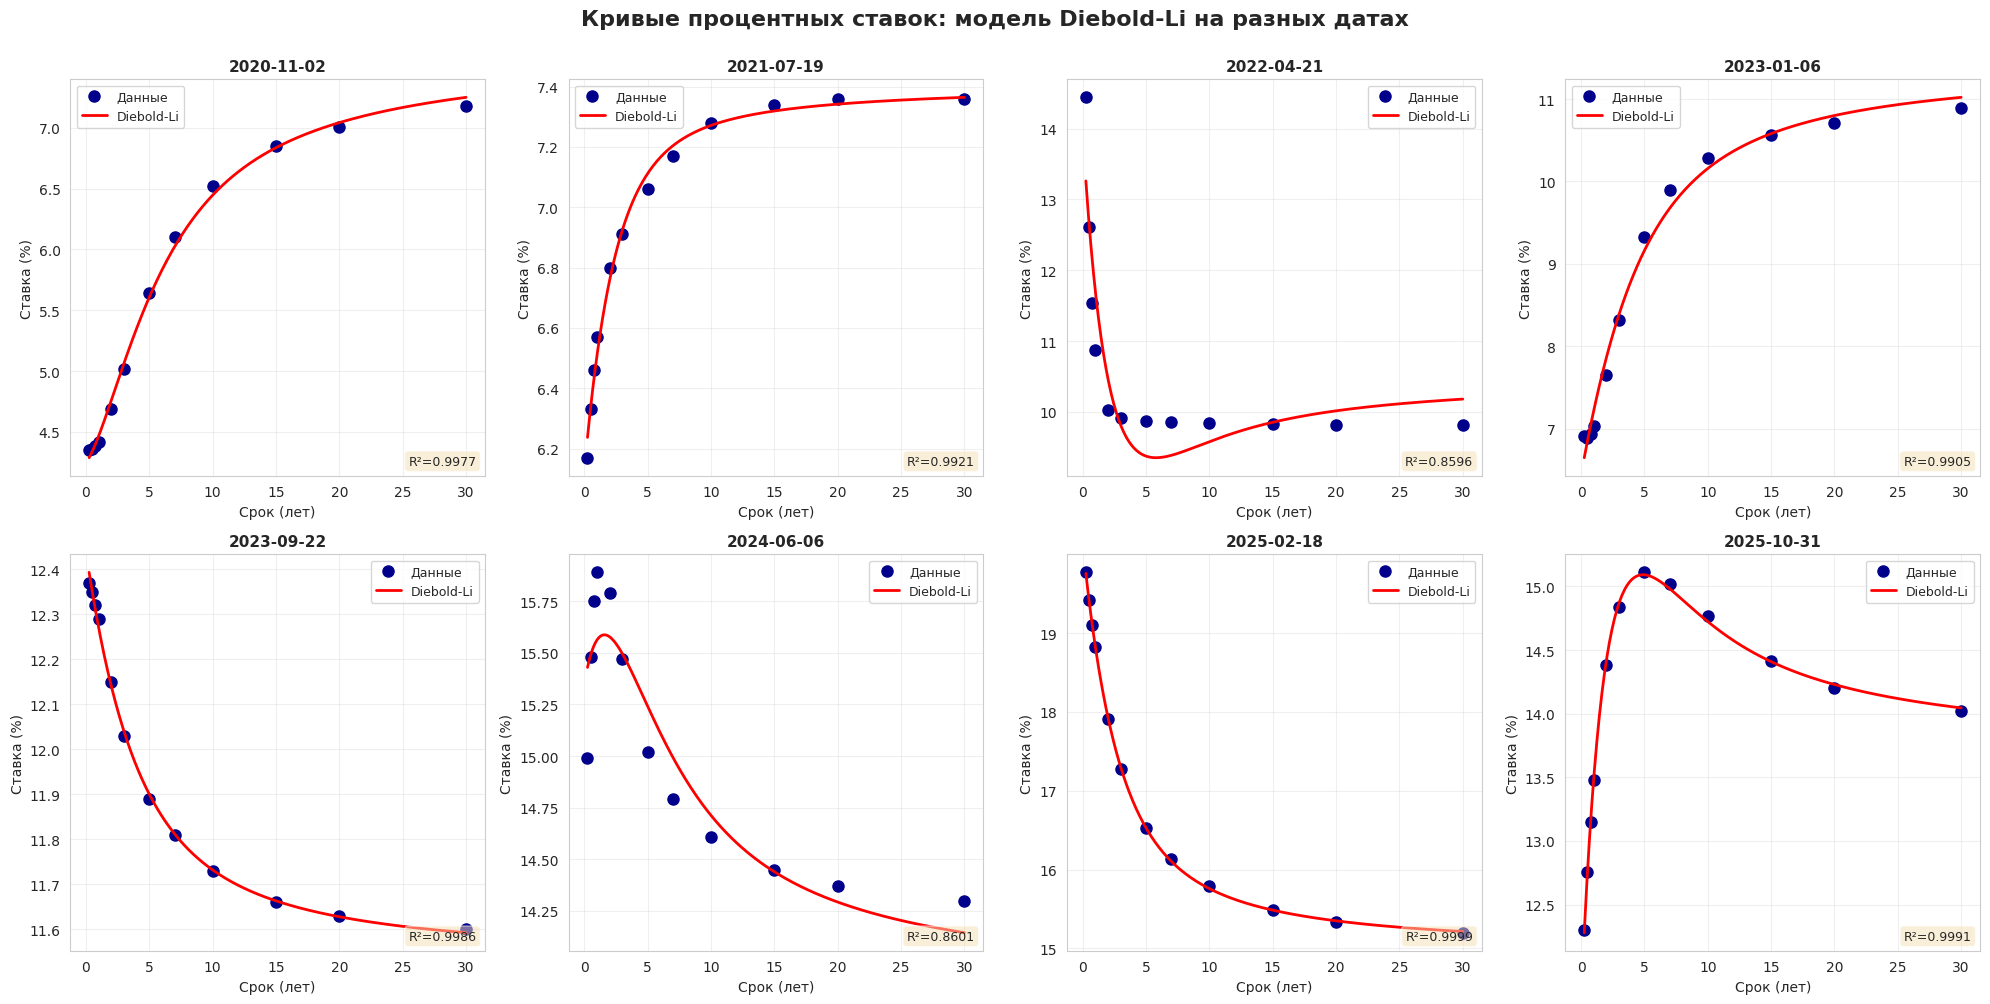

In [10]:
# Визуализация кривых доходности для нескольких выбранных дат

# Выберем несколько равноотстоящих дат
n_samples = 8
indices = np.linspace(0, len(df)-1, n_samples, dtype=int)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

tau_fine = np.linspace(maturities.min(), maturities.max(), 300)

for i, idx in enumerate(indices):
    date = df.index[idx]
    yields = df.iloc[idx].values
    
    # Обучаем модель
    model_viz = DieboldLiModel(tau=2.0)
    model_viz.fit(maturities, yields)
    
    # Предсказания
    predicted_fine = model_viz.predict(tau_fine)
    
    # График
    axes[i].plot(maturities, yields, 'o', markersize=8, label='Данные', color='darkblue')
    axes[i].plot(tau_fine, predicted_fine, '-', linewidth=2, label='Diebold-Li', color='red')
    axes[i].set_title(f'{date.date()}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Срок (лет)', fontsize=10)
    axes[i].set_ylabel('Ставка (%)', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)
    
    # Добавим метрики на график
    metrics = model_viz.score(maturities, yields)
    axes[i].text(0.98, 0.02, f'R²={metrics["R²"]:.4f}', 
                transform=axes[i].transAxes, fontsize=9,
                verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Кривые процентных ставок: модель Diebold-Li на разных датах', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


In [12]:
# Сохранение результатов

# Сохраняем результаты в CSV
output_file = 'diebold_li_results.csv'
results_df.to_csv(output_file)
print(f"✓ Результаты сохранены в файл: {output_file}")

# Также создадим сводную статистику
summary = {
    'Метрика': ['RMSE (среднее)', 'RMSE (мин)', 'RMSE (макс)', 
                'R² (среднее)', 'R² (мин)', 'R² (макс)',
                'MAE (среднее)', 'MAE (мин)', 'MAE (макс)'],
    'Значение': [
        results_df['rmse'].mean(),
        results_df['rmse'].min(),
        results_df['rmse'].max(),
        results_df['r2'].mean(),
        results_df['r2'].min(),
        results_df['r2'].max(),
        results_df['mae'].mean(),
        results_df['mae'].min(),
        results_df['mae'].max()
    ]
}

summary_df = pd.DataFrame(summary)
summary_file = 'diebold_li_summary.csv'
summary_df.to_csv(summary_file, index=False)
print(f"✓ Сводная статистика сохранена в файл: {summary_file}")

print("\nСводная статистика:")
print(summary_df.to_string(index=False))


✓ Результаты сохранены в файл: diebold_li_results.csv
✓ Сводная статистика сохранена в файл: diebold_li_summary.csv

Сводная статистика:
       Метрика  Значение
RMSE (среднее)  0.120277
    RMSE (мин)  0.003140
   RMSE (макс)  0.619028
  R² (среднее)  0.926478
      R² (мин)  0.024149
     R² (макс)  0.999980
 MAE (среднее)  0.099840
     MAE (мин)  0.002474
    MAE (макс)  0.485609


## Заключение

**Реализована модель Diebold-Li для моделирования кривой процентных ставок:**

**Модель:**
- Формула: y(t) = β₀ + β₁ × [(1 - e^(-t/τ))/(t/τ)] + β₂ × [(1 - e^(-t/τ))/(t/τ) - e^(-t/τ)]
- 3 параметра: β₀ (уровень), β₁ (slope), β₂ (curvature)
- τ = 2 (фиксирован)

**Метод обучения:**
- **Ordinary Least Squares (OLS)** - аналитическое решение
- τ фиксирован на уровне 2 лет (как в оригинальной статье Diebold-Li, 2006)
- При фиксированном τ модель становится **линейной** по β₀, β₁, β₂
- Решается напрямую через формулу: β = (X^T X)^(-1) X^T y
- Быстро, стабильно, нет проблем сходимости

**Преимущества модели Diebold-Li:**
- **Простота**: всего 3 параметра против 5 в модели Bliss
- **Интерпретируемость**: 
  - β₀ = долгосрочный уровень
  - β₁ = наклон кривой (slope) = краткосрочная ставка - долгосрочная
  - β₂ = кривизна (curvature) = горб/впадина на средних сроках
- **Быстрота**: меньше параметров = быстрее обучение
- **Стабильность**: фиксированный τ устраняет проблему идентификации

**Результаты:**
- Модель успешно обучена на всех датах датасета
- Хорошее качество аппроксимации кривой доходности
- Параметры модели изменяются во времени, отражая динамику процентных ставок
- Фиксированный τ = 2 позволяет фокусироваться на экономической интерпретации β₀, β₁, β₂

**Применение:**
- Прогнозирование процентных ставок для любых сроков погашения
- Анализ формы кривой доходности (нормальная, инвертированная, плоская)
- Факторный анализ: level, slope, curvature
- Управление процентным риском
- Ценообразование облигаций
- **Популярна в центральных банках** для мониторинга кривой доходности
